# 1-parameter interpolation for single-qubit $R_X$ gate

In [1]:
import random
from scipy.spatial import Delaunay
from qctrl_optimize import hamiltonians
from qctrl_optimize import optimize as opt
from qctrl_optimize import gates
from qctrl_optimize import simulate as sim
from qctrl_optimize import interpolate as interp
from qctrl_optimize import plot as plotter
from qctrl import Qctrl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle
from itertools import product
qctrl = Qctrl()

In [2]:
# Set up parameters for the Interpolater

num_pwc_segments = 20
segment_count = 500
duration = np.pi
sample_times = np.linspace(0, duration, segment_count)
amplitude = 1
tik0 = 1e-2
tik0 = tik0 / (amplitude**2 * num_pwc_segments)
seed = 0 # reproducability

# get sets of reference points and testing points
granularity_train = 1/6
granularity_test = 1/12
npts_train = int(1+1/granularity_train)
npts_test = int(1+1/granularity_test)
train_points = np.array(list(np.linspace(0,2*np.pi,npts_train)))[:,None]
test_points = np.array(list(np.linspace(0,2*np.pi,npts_test)))[:,None]

# function mapping pulse signals to Hamiltonian
def sigs_to_ham(graph, signals):
    hamiltonian, _,_,= hamiltonians.simple_hamiltonian_from_signals_1q(graph, signals)
    return hamiltonian

# function mapping (graph, target, signals) => graph.infidelity
infid_func = opt.get_ham_infid_func(sigs_to_ham)

var_shape = (2, num_pwc_segments)
# function mapping pulse optimizable variables to signal objects
vals_to_sigs = opt.get_vals_to_sigs_pwc(duration, var_shape, amplitude)

In [3]:
# This cell will make many print statements - beware!

interpolater = interp.Interpolater(qctrl, gates.rx, tik0, interp.neighbor_avg, seed, infid_func, vals_to_sigs)

# initial optimization
opt_var_results, n_iters = interpolater.train(train_points, first_run=True)
infids, simplices, _, _ = interpolater.test_interpolations(train_points, opt_var_results, test_points)

[0.]


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1679273") has completed.
Iterations:	40
Optimized cost:	1.539e-08
Infidelity:	1.185e-10
Tikhonov:	1.527e-08
1 [[ 1.22718388e-03 -4.14645869e-04 -1.46448270e-03  4.71992685e-04
   2.87094003e-03 -9.17682088e-04 -2.28230264e-03  3.31806413e-04
  -1.03026330e-03 -1.28790730e-03  5.06699029e-04  4.01358632e-04
   3.63280959e-03 -5.13306566e-04  8.66035044e-04  4.90304818e-05
  -1.29596057e-03 -8.45751546e-04 -9.32355453e-04  5.63678917e-04]
 [ 5.78271216e-04 -1.48194360e-03  7.92447726e-04  2.68745284e-03
   2.10516788e-04  2.10397312e-04 -1.26154970e-03 -8.83881851e-04
   1.32646154e-03 -6.14383284e-04  5.59691628e-04 -3.88716778e-04
   9.39294413e-04 -3.04312625e-04  8.47248505e-04 -1.03293249e-03
  -3.36644229e-05  3.70474163e-04 -1.59572473e-03 -8.96571788e-04]]
[1.04719755]


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1679274") has completed.
Iterations:	36
Optimized cost:	1.390e-04
Infidelity:	7.539e-08
Tikhonov:	1.389e-04
[2.0943951]


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1679275") has completed.
Iterations:	42
Optimized cost:	2.221e-03
Infidelity:	1.137e-06
Tikhonov:	2.220e-03
[3.14159265]


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1679276") has completed.
Iterations:	31
Optimized cost:	1.249e-03
Infidelity:	6.452e-07
Tikhonov:	1.249e-03
[4.1887902]


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1679277") has completed.
Iterations:	37
Optimized cost:	5.553e-04
Infidelity:	2.839e-07
Tikhonov:	5.550e-04
[5.23598776]


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1679278") has completed.
Iterations:	37
Optimized cost:	1.388e-04
Infidelity:	7.020e-08
Tikhonov:	1.388e-04
[6.28318531]


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1679279") has completed.
Iterations:	40
Optimized cost:	1.539e-08
Infidelity:	1.185e-10
Tikhonov:	1.527e-08
(2, 20)
(2, 20)
(2, 20)
(2, 20)
(2, 20)
(2, 20)
(2, 20)
(2, 20)
(2, 20)
(2, 20)
(2, 20)
(2, 20)
(2, 20)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph (action_id="1679280") has completed.
infidelity_0: 	1.185e-10
infidelity_1: 	6.872e-08
infidelity_2: 	7.539e-08
infidelity_3: 	1.000e+00
infidelity_4: 	1.137e-06
infidelity_5: 	9.825e-07
infidelity_6: 	6.452e-07
infidelity_7: 	4.621e-07
infidelity_8: 	2.839e-07
infidelity_9: 	1.600e-07
infidelity_10: 	7.020e-08
infidelity_11: 	2.495e-08
infidelity_12: 	1.185e-10


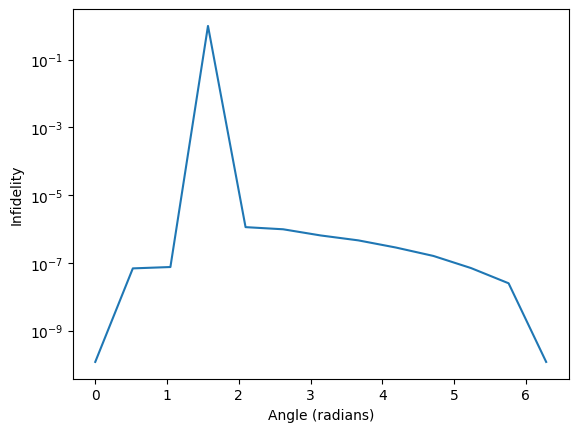

In [4]:
import matplotlib.pyplot as plt
plt.plot(test_points[:,0], infids)
plt.yscale('log')
plt.ylabel('Infidelity')
plt.xlabel('Angle (radians)')
plt.show()

We observe relatively good interpolation accuracy except in between $\theta = \pi$ and $\theta = \frac 7 6 \pi$. Intuitively, a single-qubit rotation is like "walking around" the Bloch sphere in some direction for some angle. The two pulses that we are interpolating between are trying to walk around the sphere in two different directions (because there are two ways to do an X rotation and end up on the opposite side of the sphere), so they interpolate poorly.

The solution to this problem is to break the parameter space into two regions, one for angles in $[0,\pi]$ and one for angles in $[\pi, 2\pi]$. This does not add much computation time but fixes the interpolation problem.